<a href="https://colab.research.google.com/github/satyajitghana/ProjektDepth/blob/master/notebooks/09_DepthModel_Experiments_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments on TPU

In [0]:
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  17619      0 --:--:-- --:--:-- --:--:-- 17547
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
Uninstalling torch-1.5.0+cu101:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][114.5 MiB/114.5 MiB]                                                
Operation completed over 1 objec

In [0]:
import os
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
    print('TPU not found')

Found TPU at: grpc://10.114.205.82:8470


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
from pathlib import Path
from zipfile import ZipFile
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import gc
from tqdm.auto import tqdm, trange
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchsummary import summary
import torch.nn as nn
import torchvision.transforms as T
import glob
import torch
import sys
from typing import List, Tuple
import yaml
import numpy as np
import time
import torch.nn.functional as F
import torch.optim as optim
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import sys
sys.path.insert(0, 'ProjektDepth')

In [0]:
! git clone https://github.com/satyajitghana/ProjektDepth.git

Cloning into 'ProjektDepth'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 55 (delta 22), reused 42 (delta 11), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [0]:
import vathos.data_loader as vloader
import vathos.model as vmodel

In [0]:
%%time
dataset = vloader.DenseDepth(root='data', source_zipfolder='/content/gdrive/My Drive/DepthProject/depth_dataset_zipped/',
                     transform=T.Compose([T.ToTensor()]), target_transform=T.Compose([T.ToTensor()]))

Extracting the zip files


Extracting bg_small.zip ...
Extracting fg_bg_small.zip ...
Extracting fg_bg_mask_small.zip ...
Extracting depth_fg_bg_small.zip ...

found 100 bg images, 400000 fg_bg images, 400000 fg_bg_mask images, 400000 depth_fg_bg images
CPU times: user 1min 51s, sys: 59 s, total: 2min 50s
Wall time: 3min 6s


## Split the Data into Test and Train

In [0]:
%%time
# 70 - 30 split
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_subset, test_subset = torch.utils.data.random_split(dataset, [train_size, test_size])

CPU times: user 30.2 ms, sys: 12.9 ms, total: 43.1 ms
Wall time: 171 ms


In [0]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn


class ResDoubleConv(nn.Module):
    '''Basic DoubleConv of a ResNetV2'''

    def __init__(self, in_channels, out_channels):
        super(ResDoubleConv, self).__init__()

        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,
                      kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out


class ResDownBlock(nn.Module):
    '''Basic DownBlock of a ResNetV2'''

    def __init__(self, in_channels, out_channels):
        super(ResDownBlock, self).__init__()

        self.double_conv = ResDoubleConv(in_channels, out_channels)

        self.proj_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.down_sample = nn.MaxPool2d(2)

    def forward(self, input):
        identity = self.proj_layer(input)
        out = self.double_conv(input)
        out = out + identity

        return self.down_sample(out), out


class ResUpBlock(nn.Module):
    '''Basic UpBlock of a ResNetV2'''

    def __init__(self, in_channels, out_channels):
        super(ResUpBlock, self).__init__()

        self.pre_conv = nn.Conv2d(in_channels, in_channels*4, kernel_size=1, bias=False)

        self.skip_conv = nn.Conv2d(out_channels, in_channels, kernel_size=1, bias=False)

        self.upsample = nn.PixelShuffle(2)

        self.double_conv = ResDoubleConv(in_channels, out_channels)

        self.proj_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, down_input, skip_input):

        x = self.pre_conv(down_input)

        x = self.upsample(x) + self.skip_conv(skip_input)

        identity = self.proj_layer(x)

        out = self.double_conv(x) + identity

        return out


class ResUNet(nn.Module):
    def __init__(self):
        super(ResUNet, self).__init__()

        # Encoder
        # H / 2   ; input = 192x192x6 ; output = 96x96x64   ; skip1 = 192x192x64
        self.res_down1 = ResDownBlock(6, 64)
        # H / 4   ; input = 96x96x64  ; output = 48x48x128  ; skip2 = 96x96x128
        self.res_down2 = ResDownBlock(64, 128)
        # H / 8   ; input = 48x48x128 ; output = 24x24x256  ; skip3 = 48x48x256
        self.res_down3 = ResDownBlock(128, 256)
        # H / 16  ; input = 24x24x256 ; output = 12x12x512  ; skip4 = 24x24x512
        self.res_down4 = ResDownBlock(256, 512)

        # Bridge
        self.bridge = ResDoubleConv(512, 512)

        # Depth Decoder
        # H / 8  ; input = 24x24x512(upscaled)   24x24x512(skip4)  ; output = 24x24x512(dskip4)
        self.d_res_up4 = ResUpBlock(512, 512)
        # H / 4  ; input = 48x48x512(upscaled)   48x48x256(skip3)  ; output = 48x48x256(dskip3)
        self.d_res_up3 = ResUpBlock(512, 256)
        # H / 2  ; input = 96x96x256(upscaled)   96x96x128(skip2)  ; output = 96x96x128(dskip2)
        self.d_res_up2 = ResUpBlock(256, 128)
        # H / 1  ; input = 192x192x128(upscaled) 192x192x64(skip1) ; output = 192x192x64(dskip1)
        self.d_res_up1 = ResUpBlock(128, 64)

        # Depth Output
        self.depth_output = nn.Conv2d(
            64, 1, kernel_size=1, stride=1, bias=False)  # output = 192x192x1

        # Segmentation Decoder
        # H / 8  ; input = 24x24x1024(upscaled)  24x24x512(dskip4)  24x24x512(skip4)  ; output = 24x24x512
        self.s_res_up4 = ResUpBlock(512, 512)
        # H / 4  ; input = 48x48x512(upscaled)   48x48x256(dskip3)  48x48x256(skip3)  ; output = 48x48x256
        self.s_res_up3 = ResUpBlock(512, 256)
        # H / 2  ; input = 96x96x256(upscaled)   96x96x128(dskip2)  96x96x128(skip2)  ; output = 96x96x128
        self.s_res_up2 = ResUpBlock(256, 128)
        # H / 1  ; input = 192x192x128(upscaled) 192x192x64(dskip1) 192x192x64(skip1) ; output = 192x192x64
        self.s_res_up1 = ResUpBlock(128, 64)

        # Segmentation Output
        self.segment_output = nn.Conv2d(
            64, 1, kernel_size=1, stride=1, bias=False)  # output = 192x192x1

    def forward(self, input):

        # Encoder
        rd1, skip1_out = self.res_down1(input)
        rd2, skip2_out = self.res_down2(rd1)
        rd3, skip3_out = self.res_down3(rd2)
        rd4, skip4_out = self.res_down4(rd3)

        # Bridge
        bridge = self.bridge(rd4)

        # Depth Decoder
        dru4 = self.d_res_up4(bridge, skip4_out)
        dru3 = self.d_res_up3(dru4, skip3_out)
        dru2 = self.d_res_up2(dru3, skip2_out)
        dru1 = self.d_res_up1(dru2, skip1_out)

        d_out = self.depth_output(dru1)

        # Segmentation Decoder
        sru4 = self.s_res_up4(bridge, skip4_out + dru4)
        sru3 = self.s_res_up3(sru4, skip3_out + dru3)
        sru2 = self.s_res_up2(sru3, skip2_out + dru2)
        sru1 = self.s_res_up1(sru2, skip1_out + dru1)

        s_out = self.segment_output(sru1)
        return d_out, s_out

In [0]:
def apply_on_batch(batch, apply_func):
    batch['bg'] = apply_func(batch['bg'])
    batch['fg_bg'] = apply_func(batch['fg_bg'])
    batch['fg_bg_mask'] = apply_func(batch['fg_bg_mask'])
    batch['depth_fg_bg'] = apply_func(batch['depth_fg_bg'])

    return batch

In [0]:
def train_model():
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_subset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=32,
        sampler=train_sampler,
        num_workers=4
    )

    lr = 1e-2 * 8

    device = xm.xla_device()

    model = ResUNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    loss_fn = nn.BCEWithLogitsLoss()

    def train_loop_fn(loader):
        tracker = xm.RateTracker()
        model.train()

        print(f'[xla:{xm.get_ordinal()}] started', flush=True)
        epoch_loader = tqdm(loader, total=len(train_loader), desc="Iteration", disable=not xm.is_master_ordinal())
        for batch_idx, data in enumerate(epoch_loader):

            optimizer.zero_grad()

            x = torch.cat([data['bg'], data['fg_bg']], dim=1)
            d_out, s_out = model(x)

            l1 = loss_fn(d_out, data['depth_fg_bg'])
            l2 = loss_fn(s_out, data['fg_bg_mask'])

            loss = 2*l1 + l2

            loss.backward()

            xm.optimizer_step(optimizer)
            tracker.add(32)

            if batch_idx % 200 == 0:
                print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}'.format(
                    xm.get_ordinal(), batch_idx, loss.item(), tracker.rate(),
                    tracker.global_rate(), time.asctime()), flush=True)

    # single epoch
    para_loader = pl.ParallelLoader(train_loader, [device])
    train_loop_fn(para_loader.per_device_loader(device))
    xm.master_print("Finished training epoch")
    xm.save(model.state_dict(), 'save.pt')

In [0]:
def _mp_fn(rank):
    train_model()
xmp.spawn(_mp_fn, nprocs=8, start_method='fork')

[xla:0] started


[xla:2] started
[xla:0](0) Loss=2.22742 Rate=7.17 GlobalRate=7.17 Time=Tue May 19 11:18:49 2020
[xla:5] started
[xla:1] started
[xla:7] started
[xla:6] started
[xla:3] started
[xla:4] started
[xla:2](0) Loss=2.22380 Rate=5.48 GlobalRate=5.48 Time=Tue May 19 11:18:54 2020
[xla:7](0) Loss=2.22676 Rate=3.80 GlobalRate=3.80 Time=Tue May 19 11:19:00 2020
[xla:5](0) Loss=2.22443 Rate=3.80 GlobalRate=3.80 Time=Tue May 19 11:19:00 2020
[xla:1](0) Loss=2.22024 Rate=3.72 GlobalRate=3.72 Time=Tue May 19 11:19:01 2020
[xla:3](0) Loss=2.21822 Rate=3.44 GlobalRate=3.44 Time=Tue May 19 11:19:01 2020
[xla:6](0) Loss=2.22342 Rate=3.26 GlobalRate=3.26 Time=Tue May 19 11:19:02 2020
[xla:4](0) Loss=2.22519 Rate=3.65 GlobalRate=3.65 Time=Tue May 19 11:19:03 2020
[xla:0](200) Loss=1.18423 Rate=20.93 GlobalRate=29.63 Time=Tue May 19 11:22:22 2020
[xla:3](200) Loss=1.22140 Rate=20.48 GlobalRate=30.58 Time=Tue May 19 11:22:22 2020
[xla:1](200) Loss=1.23160 Rate=20.53 GlobalRate=30.59 Time=Tue May 19 11:22:22 2

In [0]:
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

In [0]:
model = ResUNet()
model.load_state_dict(torch.load('save.pt'))
model.eval()
data = next(iter(test_loader))
# data['bg'] = data['bg'].to(device)
# data['fg_bg'] = data['fg_bg'].to(device)
# data['depth_fg_bg'] = data['depth_fg_bg'].to(device)
# data['fg_bg_mask'] = data['fg_bg_mask'].to(device)
x = torch.cat([data['bg'], data['fg_bg']], dim=1)
with torch.no_grad():
    d_out, s_out = model(x)

In [0]:
def plot4_batch(batch):
    '''
    Plots 4 images for batch
    '''
    fig, ax = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey=True)

    # set the title
    for axs, col in zip(ax[0], ['BG', 'FG_BG', 'FG_BG_MASK', 'DEPTH_FG_BG']):
        axs.set_title(col)
    
    # plot the first 4 samples from the batch
    for i in range(4):
        bg, fg_bg, fg_bg_mask, depth_fg_bg = batch['bg'][i].permute(1, 2, 0).cpu().numpy(), batch['fg_bg'][i].permute(1, 2, 0).cpu().numpy(), batch['fg_bg_mask'][i][0].cpu().numpy(), batch['depth_fg_bg'][i][0].cpu().numpy()

        ax[i, 0].imshow(bg) ; ax[i, 0].axis('off')

        ax[i, 1].imshow(fg_bg) ; ax[i, 1].axis('off')

        ax[i, 2].imshow(fg_bg_mask) ; ax[i, 2].axis('off')

        ax[i, 3].imshow(depth_fg_bg) ; ax[i, 3].axis('off')

    fig.tight_layout()

    plt.show()

### After training for single epoch

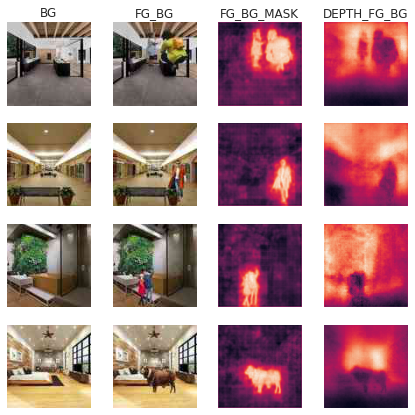

In [0]:
plot4_batch({'fg_bg': data['fg_bg'], 'bg': data['bg'], 'depth_fg_bg': d_out, 'fg_bg_mask': s_out})

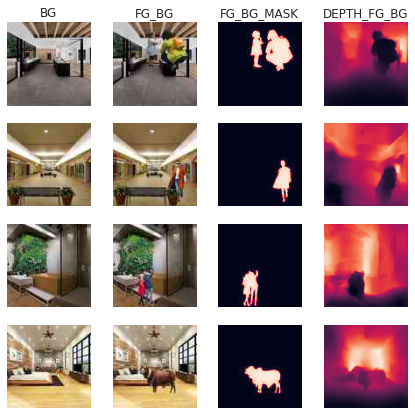

In [0]:
plot4_batch(data)

In [0]:
gc.collect()

206